# Hello PixelCNN using Tensorflow mixture distrobutions on MNIST dataset

In [1]:
# Prerequisites
import sys
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

# pip install tensorflow_probability[tf]
import tensorflow_probability as tfp

from utils import display

print("Python Version: ", sys.version)




Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


### Get Data
Use FashionMNIST from TensorFlow datasets

In [2]:

(x_train, _), (_, _) = datasets.mnist.load_data()

### Preprocess Data

Scale down in size and image depth to make the training time reasonable

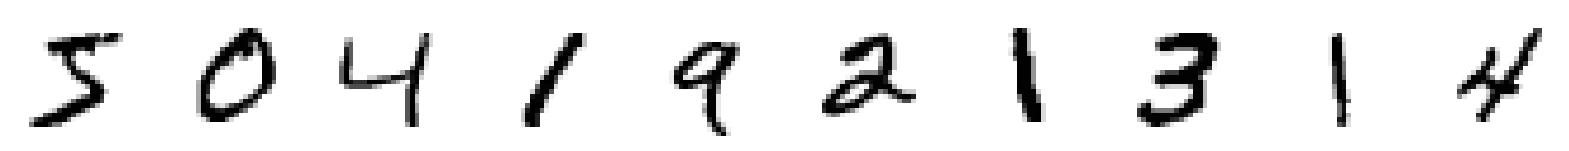

In [3]:
IMAGE_SIZE = 28 # MNIST images are 28x28 pixels

x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # (N, 28, 28, 1

# Display some sample preprocessed images
display(x_train)

### Define PixelCNN

#### Define PixelCNN itself

In [4]:
N_COMPONENTS = 5

# Define the PixelCNN distribution
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

# Define a custom Keras layer that adds the NLL loss
class LogProbLayer(layers.Layer):
    def call(self, inputs):
        log_prob = dist.log_prob(inputs)
        self.add_loss(-tf.reduce_mean(log_prob))
        return log_prob

# Keras Functional API Model
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
log_prob_output = LogProbLayer()(image_input)
pixelcnn = models.Model(inputs=image_input, outputs=log_prob_output)


### Compile and Train the PixelCNN

In [5]:
BATCH_SIZE = 128
EPOCHS = 10

# Compile and train the model
pixelcnn.compile(optimizer='adam')
pixelcnn.fit(x_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10


d:\MyGithub\ML_Generative_AI_Experiments\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


469/469 ━━━━━━━━━━━━━━━━━━━━ 124s 261ms/step - loss: 1158.9739
Epoch 2/10
 24/469 ━━━━━━━━━━━━━━━━━━━━ 1:57 265ms/step - loss: 1157.1926

KeyboardInterrupt: 

### Sample Images from trained model


In [ ]:
# Sample images from the trained model
n_samples = 16
generated_images = dist.sample(n_samples)  # shape: (n_samples, 28, 28, 1)

display(generated_images, n=n_samples)